In [2]:
!pip install xgboost

   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/72.0 MB 325.1 kB/s eta 0:03:42
   ---------------------------------------- 0.1/72.0 MB 409.6 kB/s eta 0:02:56
   ---------------------------------------- 0.1/72.0 MB 595.3 kB/s eta 0:02:01
   ---------------------------------------- 0.1/72.0 MB 599.1 kB/s eta 0:02:00
   ---------------------------------------- 0.1/72.0 MB 599.1 kB/s eta 0:02:00
   ---------------------------------------- 0.3/72.0 MB 871.5 kB/s eta 0:01:23
   ---------------------------------------- 0.3/72.0 MB 871.5 kB/s eta 0:01:23
   ---------------------------------------- 0.3/72.0 MB 824.9 kB/s eta 0:01:27
   ---------------------------------------- 0.3/72.0 MB 824.9 kB/s eta 0:01:27
   ---------------------------------------- 0.5/72.0 MB 1.1 MB/s eta 0:01:08
  

In [51]:
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import seaborn as sns
import matplotlib.pyplot as plt

# DATA LOADING AND MERGING

In [5]:
try:
    
    df_orders = pd.read_csv('orders.csv')
    df_delivery = pd.read_csv('delivery_performance.csv')
    df_routes = pd.read_csv('routes_distance.csv')
    df_cost = pd.read_csv('cost_breakdown.csv')
    df_vehicle = pd.read_csv('vehicle_fleet.csv')

    
    # Merge 
    data = df_orders.merge(df_delivery, on='Order_ID', how='left')
    data = data.merge(df_routes, on='Order_ID', how='left')
    data = data.merge(df_cost, on='Order_ID', how='left')
    
   # Calculate Carrier-level Vehicle Metrics (Aggregation)
    carrier_vehicle_metrics = df_vehicle.groupby('Current_Location').agg(
        Avg_Capacity=('Capacity_KG', 'mean'),
        Avg_Efficiency=('Fuel_Efficiency_KM_per_L', 'mean'),
        Avg_Age=('Age_Years', 'mean'),
        Avg_CO2=('CO2_Emissions_Kg_per_KM', 'mean')
    ).reset_index().rename(columns={'Current_Location': 'Origin'}) # Assuming current location maps to origin warehouse

    # Merge aggregated vehicle features onto the main data based on 'Origin'
    data = data.merge(carrier_vehicle_metrics, on='Origin', how='left')

    # Drop rows where essential delivery performance data is missing
    data.dropna(subset=['Actual_Delivery_Days', 'Promised_Delivery_Days', 'Avg_Capacity'], inplace=True)
    
    print(f"   -> Final combined dataset shape: {data.shape}")

except FileNotFoundError as e:
    print(f"Error: One of the required CSV files was not found. Please ensure all files are in the directory. Missing file: {e}")
    exit()

   -> Final combined dataset shape: (150, 33)


In [17]:
data.sample(5)

,Order_ID,Order_Date,Customer_Segment,Priority,Product_Category,Order_Value_INR,Origin,Destination,Special_Handling,Carrier,...,Avg_Age,Avg_CO2,Delivery_Delay_Days,Delivery_Delay_Hours,Load_Value_Factor,Total_Order_Cost,Cost_Efficiency_Ratio,Day_of_Week,Has_Weather_Impact,Is_Fragile
0,ORD000001,2025-10-09,Individual,Express,Industrial,238.73,Kolkata,Hyderabad,NaN,SpeedyLogistics,...,3.764268,0.394750,1.0,24.0,0.049821,458.45,1.920370,3,0,0
5,ORD000006,2025-09-21,Individual,Express,Food & Beverage,158.22,Chennai,Dubai,NaN,GlobalTransit,...,2.894543,0.339167,1.0,24.0,0.094056,389.32,2.460624,6,0,0
33,ORD000034,2025-09-16,Enterprise,Economy,Books,601.20,Mumbai,Dubai,Temperature_Controlled,ReliableExpress,...,3.896403,0.392000,1.0,24.0,0.167218,839.96,1.397139,1,0,0
101,ORD000102,2025-09-24,Individual,Economy,Food & Beverage,530.26,Mumbai,Singapore,NaN,SpeedyLogistics,...,3.896403,0.392000,2.0,48.0,0.147487,651.60,1.228831,2,1,0
7,ORD000008,2025-09-19,Enterprise,Standard,Industrial,4771.54,Chennai,Kolkata,NaN,GlobalTransit,...,2.894543,0.339167,5.0,120.0,2.836494,874.16,0.183203,4,0,0


# FEATURE ENGINEERING AND TARGET VARIABLE CREATION

In [59]:
data['Delivery_Delay_Days'] = data['Actual_Delivery_Days'] - data['Promised_Delivery_Days']
data['Delivery_Delay_Hours'] = data['Delivery_Delay_Days'] * 24  # Delivery Delay Hours and Days
data['Delay_Status'] = np.where(data['Delivery_Delay_Hours'] > 0, 'Delayed', 'On-Time/Early')

  Feature 1: Load Factor

In [7]:
data['Load_Value_Factor'] = data['Order_Value_INR'] / data['Avg_Capacity'] 
data['Load_Value_Factor'].replace([np.inf, -np.inf], 0, inplace=True) # Handle division by zero/inf

Feature 2: Cost-to-Value Ratio 

In [8]:
data['Total_Order_Cost'] = data[['Fuel_Cost', 'Labor_Cost', 'Vehicle_Maintenance', 
                                  'Insurance', 'Packaging_Cost', 'Technology_Platform_Fee', 
                                  'Other_Overhead']].sum(axis=1)
data['Cost_Efficiency_Ratio'] = data['Total_Order_Cost'] / data['Order_Value_INR']
data['Cost_Efficiency_Ratio'].replace([np.inf, -np.inf], 0, inplace=True)

Feature 3: Day of Week

In [9]:
data['Order_Date'] = pd.to_datetime(data['Order_Date'])
data['Day_of_Week'] = data['Order_Date'].dt.dayofweek 

Feature 4: Binary Weather Impact

In [10]:
data['Has_Weather_Impact'] = data['Weather_Impact'].apply(lambda x: 0 if x == 'None' or pd.isna(x) else 1)
data['Is_Fragile'] = data['Special_Handling'].apply(lambda x: 1 if x == 'Fragile' else 0)


# visualizations

In [60]:
plt.style.use('ggplot')
sns.set_theme(style="whitegrid")


  Visualization 1: Carrier Performance Hotspots


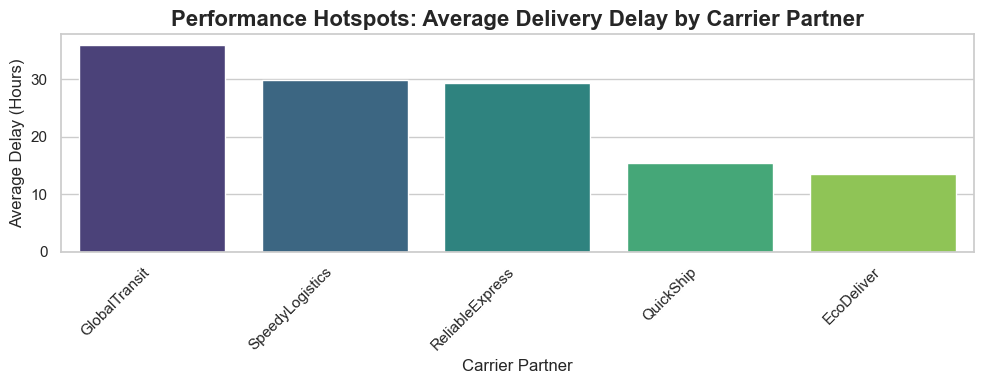

In [61]:
print("\n  Visualization 1: Carrier Performance Hotspots")
delay_carrier = data.groupby('Carrier')['Delivery_Delay_Hours'].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 4))
sns.barplot(x=delay_carrier.index, y=delay_carrier.values, palette='viridis')
plt.title('Performance Hotspots: Average Delivery Delay by Carrier Partner', fontsize=16, fontweight='bold')
plt.xlabel('Carrier Partner', fontsize=12)
plt.ylabel('Average Delay (Hours)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



 Visualization 2: Distance-Delay Trade-off...


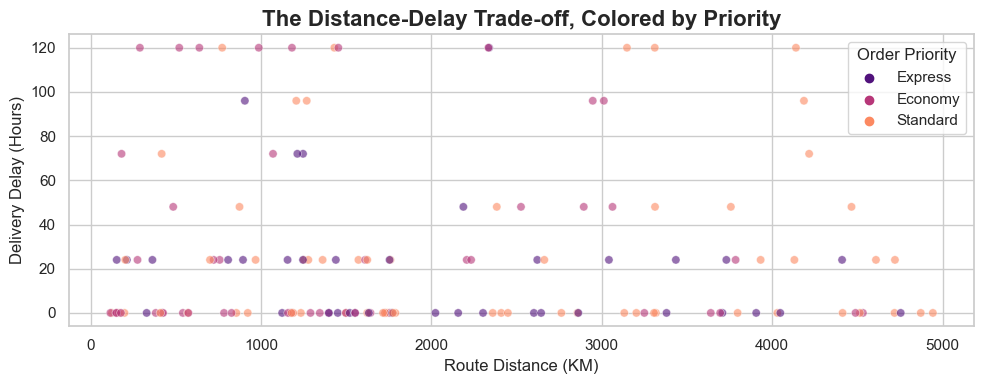

In [62]:

print("\n Visualization 2: Distance-Delay Trade-off...")

plt.figure(figsize=(10, 4))
sns.scatterplot(
    x='Distance_KM', 
    y='Delivery_Delay_Hours', 
    hue='Priority', 
    data=data, 
    alpha=0.6,
    palette='magma'
)
plt.title('The Distance-Delay Trade-off, Colored by Priority', fontsize=16, fontweight='bold')
plt.xlabel('Route Distance (KM)', fontsize=12)
plt.ylabel('Delivery Delay (Hours)', fontsize=12)
plt.legend(title='Order Priority')
plt.tight_layout()
plt.show()


 Visualization 3: Operational Cost Variance


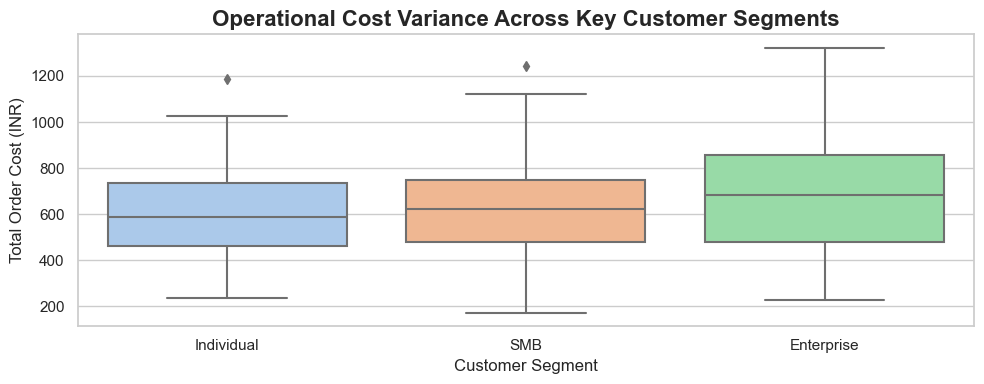

In [63]:
print("\n Visualization 3: Operational Cost Variance")

plt.figure(figsize=(10, 4))
sns.boxplot(
    x='Customer_Segment', 
    y='Total_Order_Cost', 
    data=data, 
    palette='pastel'
)
plt.title('Operational Cost Variance Across Key Customer Segments', fontsize=16, fontweight='bold')
plt.xlabel('Customer Segment', fontsize=12)
plt.ylabel('Total Order Cost (INR)', fontsize=12)
plt.tight_layout()
plt.show()




 Visualization 4: Weather Risk Quantification


<Figure size 1000x400 with 0 Axes>

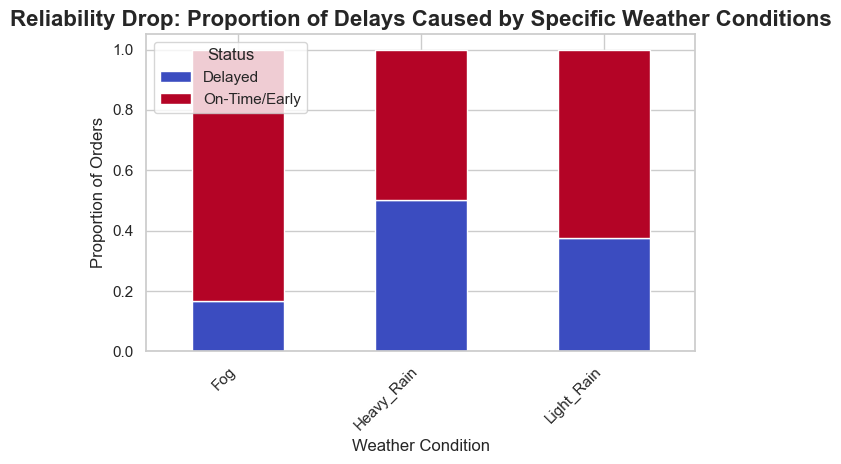

In [64]:
print("\n Visualization 4: Weather Risk Quantification")

weather_delay_counts = data.groupby(['Weather_Impact', 'Delay_Status']).size().unstack(fill_value=0)
weather_delay_proportions = weather_delay_counts.apply(lambda x: x / x.sum(), axis=1)

plt.figure(figsize=(10, 4))
weather_delay_proportions.plot(kind='bar', stacked=True, colormap='coolwarm')
plt.title('Reliability Drop: Proportion of Delays Caused by Specific Weather Conditions', fontsize=16, fontweight='bold')
plt.xlabel('Weather Condition', fontsize=12)
plt.ylabel('Proportion of Orders', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Status', loc='upper left')
plt.tight_layout()
plt.show()

# DATA PREPARATION AND PREPROCESSING PIPELINE

In [11]:
features = [
    'Order_Value_INR', 'Customer_Segment', 'Priority', 'Product_Category',
    'Origin', 'Destination', 
    'Distance_KM', 'Fuel_Consumption_L', 'Toll_Charges_INR', 'Traffic_Delay_Minutes',
    'Total_Order_Cost',
    'Avg_Capacity', 'Avg_Efficiency', 'Avg_Age', 'Avg_CO2', # Vehicle/Carrier features
    'Load_Value_Factor', 'Cost_Efficiency_Ratio', 'Day_of_Week', 'Has_Weather_Impact', 'Is_Fragile' 
]
target = 'Delivery_Delay_Hours'


In [13]:
X = data[features]
y = data[target]

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include='object').columns.tolist()


In [21]:
preprocessor = ColumnTransformer(
    transformers=[
        
        ('num', StandardScaler(), numerical_features), # Scaling numerical features
        
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features) # OHE categorical features
    ],
    remainder='passthrough'
)


# MODEL TRAINING AND OPTIMIZATION

In [23]:
def evaluate_model(model, X_test, y_test):
    """Evaluates the model and prints key metrics."""
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred) # MAE is the business-friendly metric
    return {'RMSE': rmse, 'R2': r2, 'MAE': mae}

model_results = {}
best_model = None
best_mae = float('inf')

In [33]:
# Model 1: XGBoost Regressor 
print("\n Training Model 1: Optimized XGBoost Regressor...")


xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror', 
    n_estimators=700, 
    learning_rate=0.04, 
    max_depth=6,        
    subsample=0.75,
    colsample_bytree=0.75,
    random_state=42,
    n_jobs=-1
)
pipeline_xgb = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', xgb_model)])
pipeline_xgb.fit(X_train, y_train)
results_xgb = evaluate_model(pipeline_xgb, X_test, y_test)
model_results['XGBoost'] = results_xgb
print(f"   -> XGBoost Results: MAE={results_xgb['MAE']:.2f} hrs, R2={results_xgb['R2']:.4f}")



 Training Model 1: Optimized XGBoost Regressor...
   -> XGBoost Results: MAE=30.41 hrs, R2=-0.1207


In [34]:
# Update best model
if results_xgb['MAE'] < best_mae:
    best_mae = results_xgb['MAE']
    best_model = ('XGBoost', pipeline_xgb)


In [35]:
# --- Model 2: Random Forest Regressor 
print("\n Training Model 2: Optimized Random Forest Regressor...")

rf_model = RandomForestRegressor(
    n_estimators=400,
    max_depth=12,     
    min_samples_leaf=3, 
    random_state=42, 
    n_jobs=-1
)
pipeline_rf = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', rf_model)])
pipeline_rf.fit(X_train, y_train)
results_rf = evaluate_model(pipeline_rf, X_test, y_test)
model_results['RandomForest'] = results_rf
print(f"   -> Random Forest Results: MAE={results_rf['MAE']:.2f} hrs, R2={results_rf['R2']:.4f}")



 Training Model 2: Optimized Random Forest Regressor...
   -> Random Forest Results: MAE=31.54 hrs, R2=-0.1089


In [36]:
# Update best model
if results_rf['MAE'] < best_mae:
    best_mae = results_rf['MAE']
    best_model = ('RandomForest', pipeline_rf)
    

In [37]:
# Model 3: Gradient Boosting Regressor -
print("\n Training Model 3: Optimized GBM Regressor...")

gbm_model = GradientBoostingRegressor(
    n_estimators=500, 
    learning_rate=0.07, 
    max_depth=5, 
    min_samples_split=8,
    random_state=42
)
pipeline_gbm = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', gbm_model)])
pipeline_gbm.fit(X_train, y_train)
results_gbm = evaluate_model(pipeline_gbm, X_test, y_test)
model_results['GBM'] = results_gbm
print(f"   -> GBM Results: MAE={results_gbm['MAE']:.2f} hrs, R2={results_gbm['R2']:.4f}")



 Training Model 3: Optimized GBM Regressor...
   -> GBM Results: MAE=30.01 hrs, R2=-0.1499


In [39]:
if results_gbm['MAE'] < best_mae:
    best_mae = results_gbm['MAE']
    best_model = ('GBM', pipeline_gbm)

# FINAL SELECTION AND PICKLE EXPORT

In [42]:

print("\n Final Model Selection and Export...")

# Print Summary of Results
print("\nModel Performance Summary ")
for name, results in model_results.items():
    print(f"| {name:<14} | MAE: {results['MAE']:.2f} hrs | R2: {results['R2']:.4f} |")
print("----------------------------------------------------------------")



 Final Model Selection and Export...

Model Performance Summary 
| XGBoost        | MAE: 30.41 hrs | R2: -0.1207 |
| RandomForest   | MAE: 31.54 hrs | R2: -0.1089 |
| GBM            | MAE: 30.01 hrs | R2: -0.1499 |
----------------------------------------------------------------


In [48]:
# The final best model
final_model_name = best_model[0]
final_model = best_model[1]


print(f"    The best performing model is: {final_model_name} (MAE: {best_mae:.2f} hrs)")


    The best performing model is: GBM (MAE: 30.01 hrs)


In [47]:

# Export the entire pipeline (including preprocessing steps)
pickle_filename = 'best_delivery_delay_predictor.pkl'

with open(pickle_filename, 'wb') as file:
    pickle.dump(final_model, file)

print(f"    Successfully saved the entire model pipeline to '{pickle_filename}'.")



    Successfully saved the entire model pipeline to 'best_delivery_delay_predictor.pkl'.
